In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import math
import warnings

In [14]:
#HISTORICAL_DATA________________________________________
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

def generate_realistic_ledger_data(num_records=10000, anomaly_rate=0.03):
    """
    Generates a one-year historical realistic dataset for ledger account anomaly detection.
    """

    data = []
    end_date = datetime(2023, 12, 31)
    start_date = end_date - timedelta(days=364)
    companies = ['Alpha Corp', 'Beta Ltd', 'Gamma Inc', 'Delta Solutions', 'Epsilon Tech', 'Omega Services', 'Sigma Group', 'Lambda Systems', 'Theta Holdings', 'Kappa Ventures']
    currencies = ['USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD', 'CHF', 'CNY', 'SEK', 'NZD']
    accounts = list(range(1000, 1050))
    primary_accounts = list(range(2000, 2020))
    secondary_accounts = list(range(3000, 3020))

    for i in range(num_records):
        date = start_date + timedelta(days=random.randint(0, 364))
        company = random.choice(companies)
        account = random.choice(accounts)
        au = round(np.random.lognormal(mean=5, sigma=1), 2)  # Log-normal distribution for more realistic amounts
        currency = random.choice(currencies)
        primary_account = random.choice(primary_accounts)
        secondary_account = random.choice(secondary_accounts)
        gl_balance = round(np.random.lognormal(mean=12, sigma=2), 2)  # Log-normal for balances
        ihub_balance = gl_balance + round(random.uniform(-gl_balance * 0.01, gl_balance * 0.01), 2)  # Small variations
        is_anomaly = 0
        anomaly_type = None

        if random.random() < anomaly_rate:
            is_anomaly = 1
            anomaly_type = random.choice(['Unusual Amount', 'Unusual Balance Difference', 'Unusual Account Pairing', 'Unusual Time'])

            if anomaly_type == 'Unusual Amount':
                au = round(np.random.lognormal(mean=10, sigma=2), 2)  # Much larger amounts
            elif anomaly_type == 'Unusual Balance Difference':
                ihub_balance = gl_balance + round(random.uniform(gl_balance * 0.1, gl_balance * 0.5), 2)  # Larger differences
            elif anomaly_type == 'Unusual Account Pairing':
                if random.random() < 0.5:
                    primary_account = random.choice(list(range(2021, 2030)))
                else:
                    secondary_account = random.choice(list(range(3021, 3030)))
            elif anomaly_type == 'Unusual Time':
                if random.random() < 0.5:
                    date = date.replace(hour=random.randint(0, 4))
                else:
                    date = date.replace(hour=random.randint(22, 23))

        data.append([date, company, account, au, currency, primary_account, secondary_account, gl_balance, ihub_balance])

    df = pd.DataFrame(data, columns=['Date', 'Company', 'Account', 'AU', 'Currency', 'PrimaryAccount', 'SecondaryAccount', 'GL Balance', 'IHUB Balance'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Generate the realistic dataset
realistic_ledger_data = generate_realistic_ledger_data(num_records=10000, anomaly_rate=0.03)

# Display the first few rows
print(realistic_ledger_data.head())

df = realistic_ledger_data
# Save to CSV
realistic_ledger_data.to_csv("historical_realistic_ledger_data.csv", index=False)

        Date          Company  Account      AU Currency  PrimaryAccount  \
0 2023-03-15       Alpha Corp     1042  165.81      AUD            2009   
1 2023-06-30   Lambda Systems     1027   82.65      CNY            2017   
2 2023-05-27  Delta Solutions     1016  188.69      CAD            2005   
3 2023-09-25      Sigma Group     1014   48.18      AUD            2014   
4 2023-03-11      Sigma Group     1047   74.82      CNY            2009   

   SecondaryAccount  GL Balance  IHUB Balance  
0              3022   142297.59     142099.36  
1              3011   159847.15     158794.87  
2              3003   560349.00     556929.10  
3              3003   213160.03     212351.13  
4              3007  5631810.80    5622504.49  


In [15]:
#check for null values

df.isnull().sum()

df = df.dropna()
df = df.drop_duplicates()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 - 6s - 18ms/step - loss: 1.2015e-04
Epoch 2/10
313/313 - 3s - 9ms/step - loss: 1.1896e-04
Epoch 3/10
313/313 - 3s - 9ms/step - loss: 1.1968e-04
Epoch 4/10
313/313 - 3s - 9ms/step - loss: 1.1938e-04
Epoch 5/10
313/313 - 3s - 9ms/step - loss: 1.1911e-04
Epoch 6/10
313/313 - 3s - 9ms/step - loss: 1.1935e-04
Epoch 7/10
313/313 - 3s - 9ms/step - loss: 1.1927e-04
Epoch 8/10
313/313 - 3s - 9ms/step - loss: 1.1888e-04
Epoch 9/10
313/313 - 3s - 9ms/step - loss: 1.1959e-04
Epoch 10/10
313/313 - 3s - 8ms/step - loss: 1.1925e-04
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


<ipython-input-16-977acc49fbca>:73: RuntimeWarning: invalid value encountered in greater
  data.loc[mse_full > threshold, 'Anomaly'] = 1


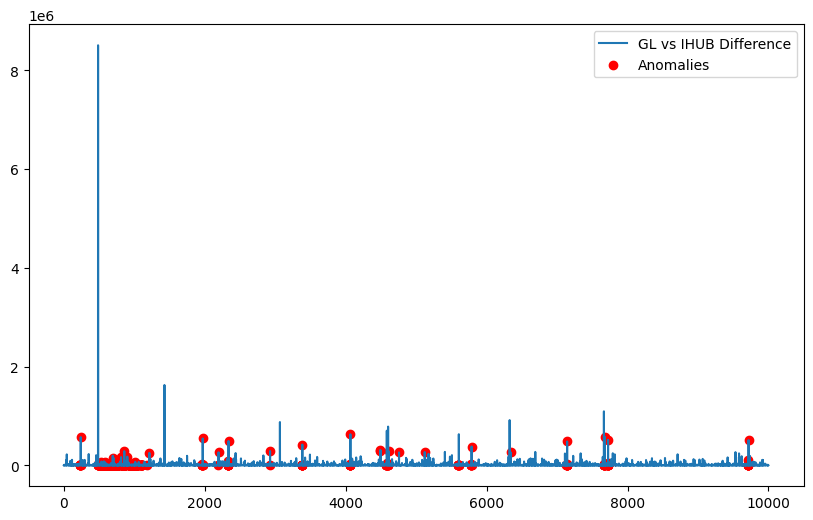

ARIMA+LSTM model saved as 'arima_lstm_anomaly_detection_model.h5'


In [16]:

#MODEL******************************************************************
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
#data = pd.read_csv("historical_realistic_ledger_data.csv")
data = df

# Feature engineering
data['GL vs IHUB Difference'] = abs(data['GL Balance'] - data['IHUB Balance'])

# Step 1: Fit ARIMA
def fit_arima(data, column, ar_order=2, d_order=1, ma_order=2):
    arima_model = ARIMA(data[column], order=(ar_order, d_order, ma_order))
    arima_fit = arima_model.fit()
    residuals = arima_fit.resid
    return residuals

# Fit ARIMA model and calculate residuals
arima_residuals = fit_arima(data, 'GL vs IHUB Difference')

# Step 2: Normalize residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_residuals = scaler.fit_transform(arima_residuals.values.reshape(-1, 1))

# Prepare time-series data for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(normalized_residuals, time_steps)

# Reshape X to be compatible with LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 3: Build and train LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=10, batch_size=32, verbose=2)

# Step 4: Predict anomalies
y_pred = model.predict(X)


# Calculate Mean Squared Error
mse = np.mean(np.power(y - y_pred, 2), axis=1)

# Pad the mse array to match the original dataframe length
mse_full = np.zeros(len(data))
mse_full[:len(mse)] = mse  # Fill MSE values where available
mse_full[len(mse):] = np.nan  # Add NaN for rows that couldn't be processed due to time steps

# Set dynamic anomaly threshold (e.g., 95th percentile of non-NaN values)
threshold = np.nanpercentile(mse_full, 95)

# Assign anomalies to the dataframe
data['Anomaly'] = 0
data.loc[mse_full > threshold, 'Anomaly'] = 1

# Visualize anomalies (optional)
plt.figure(figsize=(10, 6))
plt.plot(data['GL vs IHUB Difference'], label='GL vs IHUB Difference')
plt.scatter(data.index[data['Anomaly'] == 1], data['GL vs IHUB Difference'][data['Anomaly'] == 1],
            color='red', label='Anomalies')
plt.legend()
plt.show()





# Save the model
model_anamoly = model
import joblib
joblib.dump(model, "arima_lstm_anomaly_detection_model.h5")

#model.save("arima_lstm_anomaly_detection_model.h5")
print("ARIMA+LSTM model saved as 'arima_lstm_anomaly_detection_model.h5'")


In [17]:
# TEST_DATA***********************************************************

import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np

# Define constants
NUM_ROWS = 10000
COMPANIES = ["Alpha Inc", "Beta Ltd", "Gamma LLC", "Delta Inc", "Epsilon"]
ACCOUNTS = ["ACC001", "ACC002", "ACC003", "ACC004", "ACC005"]
AUS = ["AU01", "AU02", "AU03", "AU04", "AU05"]
CURRENCIES = ["USD", "EUR", "INR", "GBP", "JPY"]
PRIMARY_ACCOUNTS = ["PA001", "PA002", "PA003", "PA004", "PA005"]
SECONDARY_ACCOUNTS = ["SA001", "SA002", "SA003", "SA004", "SA005"]

# Generate random data
def generate_data(num_rows):
    data = []
    start_date = datetime(2025, 1, 1)
    for _ in range(num_rows):
        row = {
            "Date": (start_date + timedelta(days=random.randint(0, 364))).strftime("%Y-%m-%d"),
            "Company": random.choice(COMPANIES),
            "Account": random.choice(ACCOUNTS),
            "AU": random.choice(AUS),
            "Currency": random.choice(CURRENCIES),
            "Primary Account": random.choice(PRIMARY_ACCOUNTS),
            "Secondary Account": random.choice(SECONDARY_ACCOUNTS),
            "GL Balance": round(random.uniform(5000, 15000), 2),
            "IHUB Balance": round(random.uniform(5000, 15000), 2),
        }
        data.append(row)
    return data

# Introduce imperfections
def introduce_imperfections(df):
    # Add null values randomly
    for col in random.sample(df.columns.tolist(), 3):  # Select 3 random columns to insert NaNs
        for _ in range(len(df) // 10):  # Insert NaNs in roughly 10% of rows
            df.at[random.randint(0, len(df) - 1), col] = np.nan

    # Add duplicate rows
    duplicates = df.sample(frac=0.05, random_state=42)  # 5% of data duplicated
    df = pd.concat([df, duplicates], ignore_index=True)

    # Shuffle data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

# Generate initial dataset
data = generate_data(NUM_ROWS)
df = pd.DataFrame(data)

# Introduce imperfections
df_with_issues = introduce_imperfections(df)

# Save the dataset
df_with_issues.to_csv("ledger_anomaly_dataset_realistic.csv", index=False)
print("Dataset with imperfections saved as 'ledger_anomaly_dataset_realistic.csv'")


Dataset with imperfections saved as 'ledger_anomaly_dataset_realistic.csv'


In [18]:
#check for null values
df_with_issues.isnull().sum()
df = df_with_issues

In [19]:
df = df_with_issues.dropna()

In [20]:
df = df.drop_duplicates()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<ipython-input-21-7ca055707006>:57: RuntimeWarning: invalid value encountered in greater
  data.loc[mse_full > threshold, 'Anomaly'] = 1


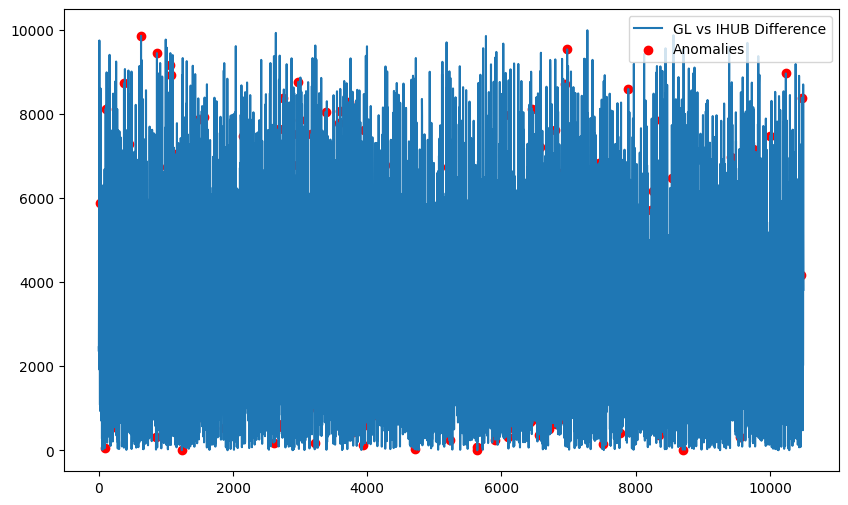

Updated dataset saved with 'Reason for Anomaly' column.


In [21]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load dataset
#data = pd.read_csv("ledger_anomaly_dataset.csv")
data=df
data['GL vs IHUB Difference'] = abs(data['GL Balance'] - data['IHUB Balance'])

# Fit ARIMA and calculate residuals
def fit_arima(data, column, ar_order=2, d_order=1, ma_order=2):
    arima_model = ARIMA(data[column], order=(ar_order, d_order, ma_order))
    arima_fit = arima_model.fit()
    residuals = arima_fit.resid
    return residuals

arima_residuals = fit_arima(data, 'GL vs IHUB Difference')

# Normalize the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_residuals = scaler.fit_transform(arima_residuals.values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, time_steps=10):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
    return np.array(X)

time_steps = 10
X_new = create_sequences(normalized_residuals, time_steps)
X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)

# Load the model and make predictions
#model = load_model("arima_lstm_anomaly_detection_model.h5")



# Load the trained model
model = joblib.load("arima_lstm_anomaly_detection_model.h5")

predictions = model.predict(X_new)

# Calculate MSE and detect anomalies
mse = np.mean(np.power(normalized_residuals[time_steps:] - predictions.flatten(), 2), axis=1)
mse_full = np.zeros(len(data))
mse_full[:len(mse)] = mse
mse_full[len(mse):] = np.nan

threshold = np.percentile(mse, 95)
data['Anomaly'] = 0
data.loc[mse_full > threshold, 'Anomaly'] = 1

# Assign reasons for anomalies
def assign_anomaly_reason(row):
    if row['Anomaly'] == 1:
        if row['GL vs IHUB Difference'] > row['GL Balance'] * 0.2:
            return "High Balance Difference"
        else:
            return "Unusual Transaction Pattern"
    return "No Anomaly"

data['Reason for Anomaly'] = data.apply(assign_anomaly_reason, axis=1)

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.plot(data['GL vs IHUB Difference'], label='GL vs IHUB Difference')
plt.scatter(data.index[data['Anomaly'] == 1], data['GL vs IHUB Difference'][data['Anomaly'] == 1],
            color='red', label='Anomalies')
plt.legend()
plt.show()

# Save updated dataset
data.to_csv("updated_ledger_dataset.csv", index=False)
print("Updated dataset saved with 'Reason for Anomaly' column.")


In [22]:
df.head

<bound method NDFrame.head of              Date    Company Account    AU Currency Primary Account  \
0      2025-08-17  Alpha Inc  ACC003  AU03      JPY           PA003   
1      2025-04-10   Beta Ltd  ACC001  AU01      GBP           PA001   
6      2025-05-25  Delta Inc  ACC003  AU03      USD           PA004   
7      2025-09-26   Beta Ltd  ACC001  AU02      USD           PA005   
8      2025-05-01  Gamma LLC  ACC004  AU05      GBP           PA002   
...           ...        ...     ...   ...      ...             ...   
10494  2025-05-29  Alpha Inc  ACC004  AU01      GBP           PA005   
10495  2025-01-01  Alpha Inc  ACC005  AU04      USD           PA002   
10496  2025-01-08  Gamma LLC  ACC004  AU01      USD           PA001   
10497  2025-05-02  Gamma LLC  ACC001  AU04      EUR           PA001   
10499  2025-11-11    Epsilon  ACC003  AU02      INR           PA003   

      Secondary Account  GL Balance  IHUB Balance  GL vs IHUB Difference  \
0                 SA005     6883.91      